In [1]:
import sys
sys.path.append('./../../')
sys.path.append('./..')
sys.path.append('./../../designer/script/')


from film import FreeFormFilm, BaseFilm, TwoMaterialFilm, EqOTFilm
from design import BaseDesign
from spectrum import BaseSpectrum, Spectrum
from optimizer.adam import AdamFreeFormOptimizer

from analyze_utils.make_design import make_edgefilter_design, make_triband_filter_design, make_reflection_design, get_minus_filter_spec

from utils.loss import calculate_RMS_f_spec
from analyze_utils.result_io import save, load
from analyze_utils.structure import plot_layer_thickness

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import copy
import pickle

Matplotlib is building the font cache; this may take a moment.


In [2]:
# design = make_edgefilter_design()
# design = make_reflection_design(wls=np.linspace(695, 939, 500))
reps = 1

n_min = 1.5
n_max = 3

# adam optimizer parameters
alpha = 1e-2
batch_size = None
max_steps=500
show = False

def exp(n_size, each_ot, target):
    np.random.seed()
    init_n = np.random.random(n_size) + 1.5
    init_film = EqOTFilm(init_n, each_ot * n_size, substrate=1.5)

    adam_optimizer = AdamFreeFormOptimizer(
        init_film, 
        target, 
        max_steps=max_steps, 
        alpha=alpha, # 0.01 for big OT films...
        record=True, 
        show=show, 
        n_min=n_min, # 1.5
        n_max=n_max, # 2.5
        wl_batch_size=batch_size # full 
    )

    adam_optimizer.optimize()
    return calculate_RMS_f_spec(init_film, target), init_film



#### Experiment: scan n_size AND each ot

In [3]:
each_ots = np.array([i for i in 10 ** np.linspace(-1, 3, 50)])
n_sizes = np.array([int(i) for i in 10 ** np.linspace(0, 4, 50)])

# wl_min = 500
# wl_max = 1000 # 1 / wl_max - 1 / wl_min = 1 / 1000

target = make_triband_filter_design().target_specs # 1 / wl_max - 1 / wl_min = 



films_arr_rep, best_loss_arr_rep, best_film_arr_rep = [], [], []
for rep in range(reps):
    films_arr_rep.append([])
    best_loss_arr_rep.append([])
    best_film_arr_rep.append([])
    for i, ot in enumerate(each_ots):
        films_arr_rep[-1].append([])
        best_loss_arr_rep[-1].append([])
        best_film_arr_rep[-1].append([])
        for j, n_size in enumerate(n_sizes):
            print((i + j / n_sizes.shape[0]) / each_ots.shape[0])
            best_loss, best_film = exp(n_size, ot, target)
            films_arr_rep[-1][-1].append([])
            best_loss_arr_rep[-1][-1].append(best_loss)
            best_film_arr_rep[-1][-1].append(best_film)
print(best_loss_arr_rep)

save('./raw_result/free_form_params_ot1e-1to1e3_nsize1to1e4.5_log_int_50sep', np.array(best_loss_arr_rep), np.array(best_film_arr_rep))

0.0
0.0025
0.005
0.0075
0.01
0.0125
0.015
0.017499999999999998
0.02
0.0225
0.025
0.027500000000000004
0.03
0.0325
0.034999999999999996
0.0375
0.04
0.042499999999999996
0.045
0.0475
0.05
0.052500000000000005
0.05500000000000001
0.057499999999999996
0.06
0.0625
0.065
0.0675
0.06999999999999999
0.0725
0.075
0.0775
0.08
0.08249999999999999
0.08499999999999999
0.0875
0.09
0.0925
0.095
0.0975
0.1
0.1025
0.10500000000000001
0.1075
0.11000000000000001
0.1125
0.11499999999999999
0.11750000000000001
0.12
0.12250000000000001
0.125
0.1275
0.13
0.1325
0.135
0.1375
0.13999999999999999
0.14250000000000002
0.145
0.14750000000000002
0.15
0.1525
0.155
0.1575
0.16
0.1625
0.16499999999999998
0.1675
0.16999999999999998
0.17250000000000001
0.175
0.1775
0.18
0.1825
0.185
0.1875
0.19
0.1925
0.195
0.1975
0.2
0.20249999999999999
0.205
0.20750000000000002
0.21000000000000002
0.2125
0.215
0.21749999999999997
0.22000000000000003
0.2225
0.225
0.22749999999999998
0.22999999999999998
0.2325
0.23500000000000001
0.2375

In [ ]:
f = best_film_arr_rep[-1][40][30]
wls = np.linspace(300, 900, 500)
plt.plot(wls, f.add_spec_param(0., wls).get_R())
plot_layer_thickness(EqOTFilm(f.get_n()[:40], f.get_optical_thickness(100), '1'))

In [6]:
best_loss_arr_rep, best_film_arr_rep = load('./raw_result/free_form_params_ot1e-1to1e3_nsize1to1e4.5_log_int')
best_loss_arr = best_loss_arr_rep[0]

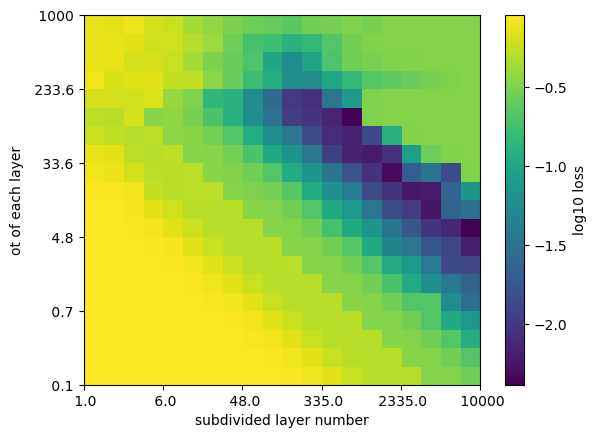

In [12]:

fig, ax = plt.subplots(1, 1)
s = ax.imshow(
    np.log10(best_loss_arr), 
    extent=[n_sizes[0], n_sizes[-1], each_ots[-1], each_ots[0]], 
    aspect='auto'
)
to_y = lambda x: (np.log10(x) - np.log10(each_ots[0])) * (-each_ots[0] + each_ots[-1]) / (-np.log10(each_ots[0]) + np.log10(each_ots[-1])) + each_ots[0]
to_x = lambda x: (np.log10(x) - np.log10(n_sizes[0])) * (-n_sizes[0] + n_sizes[-1] )/ (-np.log10(n_sizes[0]) + np.log10(n_sizes[-1])) + n_sizes[0]

if False:
    FT_lim = 1 / (1 / 400 - 1 / 400)
    ax.plot([to_x(n_sizes[0]), to_x(n_sizes[-1])], [to_y(FT_lim * 3/ 4), to_y(FT_lim * 3 / 4)], c='red', label='Fourier period limit')
    ax.plot([to_x(n_sizes[0]), to_x(n_sizes[-1])], [to_y(FT_lim * 5/ 4), to_y(FT_lim * 5 / 4)], c='red')
    ax.legend()
ax.invert_yaxis()
ax.set_ylabel('ot of each layer')
ax.set_xlabel('subdivided layer number')

make_ticks = lambda x: np.linspace(x[0], x[-1], x.shape[0] // 4 + 1)
make_tick_labels = lambda x: [f'{s: .1f}' for s in x[::4]] + [f'{x[-1]: .0f}']

ax.set_xticks(ticks=make_ticks(n_sizes), labels=make_tick_labels(n_sizes))
ax.set_yticks(ticks=make_ticks(each_ots), labels=make_tick_labels(each_ots))
# ax.set_ylim(5, None)
# ax.set_xlim(50, None)



cbar = fig.colorbar(s)
cbar.set_label('log10 loss')

fig.savefig('./results/design/Fourier/scan_ot_and_layernumber_log.png', dpi=300)

#### Experiment: gradient distribution in the film

In [ ]:
# try init with no high freq
each_ot = 1
n_size = 10000
target = make_triband_filter_design().target_specs
films, losses = exp(n_size, each_ot, target)

fig, ax = plt.subplots(1, 1)
ax.plot(np.log10(losses))

fig, ax = plt.subplots(1, 1)
s = films[-1].get_spec(0., np.linspace(400, 700, 10000))
ax.plot(s.WLS, s.get_R())

plot_layer_thickness(films[9])


optimizer_1 = AdamFreeFormOptimizer(copy.deepcopy(films[9]), target, max_steps=1, step_size=0)
optimizer_1()
fig, ax = plt.subplots(1, 1)
ax.plot(100 * np.arange(optimizer_1.g.shape[0]), optimizer_1.g)
ax.set_xlabel('position (optical thicknes) / nm')
ax.set_ylabel('gradient')

#### Experiment: fix subdivision to 1nm, optimize N

In [3]:


each_ot = 1.
n_sizes = np.array([int(i) for i in 10 ** np.linspace(4, 5, 10)])

target = [get_minus_filter_spec(np.linspace(400, 700, 5000))] # 1 / wl_max - 1 / wl_min ~ 1 / 400; max ot at: ot ~  \lambda^2 / d\lambda = 5e5

# set optimization params. overwrite exp() definition block
reps = 5
n_min = 1.5
n_max = 2.5
# adam optimizer parameters
alpha = 1e-2
batch_size = None
max_steps=200
show=True

films_arr_rep, best_loss_arr_rep, best_film_arr_rep = [], [], []
for rep in range(reps):
    films_arr_rep.append([])
    best_loss_arr_rep.append([])
    best_film_arr_rep.append([])

    for j, n_size in enumerate(n_sizes):
        print((rep + j / n_sizes.shape[0]) / reps)
        best_loss, best_film = exp(n_size, each_ot, target)
        films_arr_rep[-1].append([])
        best_loss_arr_rep[-1].append(best_loss)
        best_film_arr_rep[-1].append(best_film)

    save(f'./raw_result/free_form_params_ot{np.log10(n_sizes[0]): .1f}to{np.log10(n_sizes[-1]): .1f}_subdivision{each_ot}nm_log_int_rep_0to{rep}', np.array(best_loss_arr_rep), np.array(best_film_arr_rep))


0.0
iter 0, loss 0.26134895777346534
iter 1, loss 0.23003788637780956
iter 2, loss 0.20270369953852665
iter 3, loss 0.1807465669788259
iter 4, loss 0.16426818010929262
iter 5, loss 0.1516769690516578
iter 6, loss 0.14090106564094196
iter 7, loss 0.1306909693171296
iter 8, loss 0.12078129126974586
iter 9, loss 0.11156385855286576
iter 10, loss 0.10400870161570322
iter 11, loss 0.09890364506648393
iter 12, loss 0.09611545532752276
iter 13, loss 0.09453680062613792
iter 14, loss 0.09290861948947696
iter 15, loss 0.09058832002101791
iter 16, loss 0.0876553896712223
iter 17, loss 0.08450078224662892
iter 18, loss 0.08151505752282477
iter 19, loss 0.07897460214931408
iter 20, loss 0.07705158082190537
iter 21, loss 0.07574429939751702
iter 22, loss 0.07488816870719489
iter 23, loss 0.07425374182337353
iter 24, loss 0.07363734102438467
iter 25, loss 0.07290484029433134
iter 26, loss 0.07197200251947251
iter 27, loss 0.07080373711319796
iter 28, loss 0.06945126438872552
iter 29, loss 0.06805956

PicklingError: Can't pickle <function <lambda> at 0x000001DA4611C790>: attribute lookup <lambda> on film failed

Text(0, 0.5, 'loss')

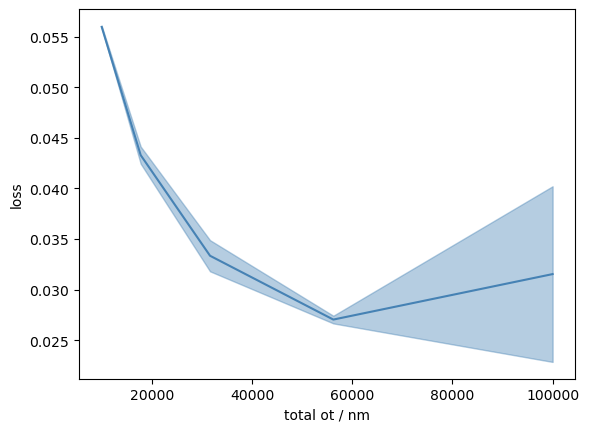

In [89]:
def plot_rep(ax, x, arr, label, c):
    arr = np.array(arr)

    ax.plot(x, arr.mean(axis=0), label=label+' mean', color=c)
    ax.fill_between(x, arr.mean(axis=0) - arr.std(axis=0), arr.mean(axis=0) + arr.std(axis=0), label=label+' mean', alpha=0.4, color=c)

from analyze_utils.violin_plot import plot_rep_violin



fig, ax = plt.subplots(1, 1)
plot_rep(ax, n_sizes * each_ot, np.array(best_loss_arr_rep), label=f'each ot {each_ot}', c='steelblue')
ax.set_xlabel('total ot / nm')
ax.set_ylabel('loss')